In [29]:
import jax.numpy as np
from jax import grad, jit, vmap
from jax import random, api
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

from svgd import SVGD, get_bandwidth

In [30]:
from jax.scipy.stats import norm

@jit
def logp(x):
    """
    IN: single scalar np array x. alternatively, [x] works too
    OUT: scalar logp(x)
    """
    return np.squeeze(np.sum(norm.logpdf(x, loc=0, scale=1)))

In [31]:
n = 50
d = 1
stepsize = 0.01
L = 3000
svgd_adaptive = SVGD(logp, n_iter_max=L, adaptive_kernel=True, get_bandwidth=get_bandwidth)

In [32]:
# generate data
rkey = random.PRNGKey(0)
x0 = random.normal(rkey, (n,1)) - 10

In [33]:
xout, log = svgd_adaptive.unjitted_svgd(x0, stepsize, bandwidth=0, n_iter=L)
xout.block_until_ready()
print()

In [34]:
st = time.time()
xout, log = svgd_adaptive.svgd(x0, stepsize, bandwidth=0, n_iter=L)
e1 = time.time()
xout.block_until_ready()
e2 = time.time()
print("until before block:", e1 - st, "s")
print("until after block:", e2 - st, "s")

COMPILING
until before block: 0.4564385414123535 s
until after block: 2.1719982624053955 s


# compare `jit`ted and non`jit`ted times

In [35]:
m = 1
generate_new_data = True

def sample_q0(rkey):
    rkey = random.split(rkey)[0]
    x0 = random.normal(rkey, (n, d))
    return x0, rkey

## Using jit

In [36]:
times_j = []
rkey = random.PRNGKey(0)

for _ in tqdm(range(m)):
    if generate_new_data:
        x0, rkey = sample_q0(rkey)
    
    st = time.time()
    xout, log = svgd_adaptive.svgd(x0, stepsize, bandwidth=0, n_iter=L)
    xout = xout.block_until_ready()
    end = time.time()
    times_j.append(end - st)
times_j = np.array(times_j)
print("mean time:", np.mean(times_j), "s")
print("stdev:", np.std(times_j), "s")

100%|██████████| 1/1 [00:01<00:00,  1.81s/it]

mean time: 1.7185051 s
stdev: 0.0 s


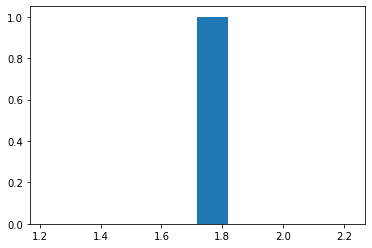

In [37]:
_ = plt.hist(times_j)

## Without jit

In [38]:
times_nojit1 = []
rkey = random.PRNGKey(0)

with api.disable_jit():
    for _ in tqdm(range(m)):
        if generate_new_data:
            x0, rkey = sample_q0(rkey)
        
        st = time.time()
        xout, log = svgd_adaptive.svgd(x0, stepsize, bandwidth=0, n_iter=L)
        xout = xout.block_until_ready()
        end = time.time()
        times_nojit1.append(end - st)
times_nojit1 = np.array(times_nojit1)
print("mean time:", np.mean(times_nojit1), "s")
print("stdev:", np.std(times_nojit1), "s")

  0%|          | 0/1 [00:00<?, ?it/s]

COMPILING


100%|██████████| 1/1 [00:02<00:00,  2.58s/it]

mean time: 2.1678054 s
stdev: 0.0 s


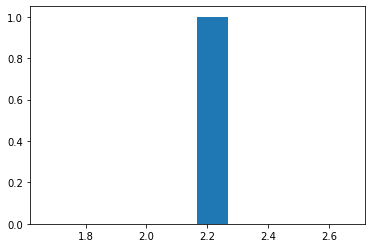

In [39]:
_ = plt.hist(times_nojit1)

In [40]:
times_nojit2 = []
rkey = random.PRNGKey(0)

for _ in tqdm(range(m)):
    if generate_new_data:
        x0, rkey = sample_q0(rkey)

    st = time.time()
    xout, log = svgd_adaptive.unjitted_svgd(x0, stepsize, bandwidth=0, n_iter=L)
    xout = xout.block_until_ready()
    end = time.time()
    times_nojit2.append(end - st)
times_nojit2 = np.array(times_nojit2)
print("mean time:", np.mean(times_nojit2), "s")
print("stdev:", np.std(times_nojit2), "s")

100%|██████████| 1/1 [00:02<00:00,  2.10s/it]

mean time: 2.0980577 s
stdev: 0.0 s


In [41]:
svgd_adaptive.n_iter_max

3000

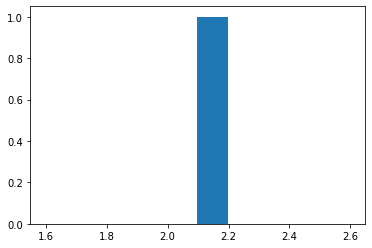

In [42]:
_ = plt.hist(times_nojit2)

# Final comparison

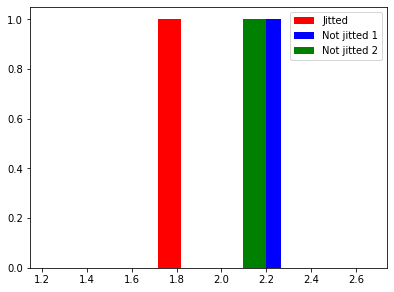

In [43]:
cols = ["r", "b", "g"]
labels = ["Jitted", "Not jitted 1", "Not jitted 2"]

fig = plt.figure(1, figsize=[6.4, 4.8])
for i, times in enumerate([times_j, times_nojit1, times_nojit2]):
    plt.hist(times, color=cols[i], label=labels[i])
    
_ = plt.legend()